In [4]:
#!{sys.executable} -m pip install matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets

In [33]:
def filter_df(df_orig, col, arg, op='=='):
    df = df_orig.copy()
    
    if op == '==':
        df = df.loc[df[col]==arg]
    elif op == '<':
        df = df.loc[df[col]<arg]
    elif op == '>':
        df = df.loc[df[col]>arg]
    elif op == '<=':
        df = df.loc[df[col]<=arg]
    elif op == '>=':
        df = df.loc[df[col]>=arg]
    elif op == '!=':
        df = df.loc[df[col]!=arg]
    elif op == 'isin':
        assert(type(arg) is list)
        df = df.loc[df[col].isin(arg)]
    else:
        print('op type not supported!')
        assert(1==0)
    
    return df

def get_path(path_string):
    path_list = [int(node_id) for node_id in path_string.split(sep=';')[2:]]
    return path_list

In [34]:
def load_data():
    config_df = pd.read_csv("../cmake-build-debug/config_log.txt", sep=",", header=0)
    display(config_df)
    config_dict = config_df.to_dict(orient='list')


    sim_df = pd.read_csv("../cmake-build-debug/sim_log.txt", sep=",", header=0)
    display(sim_df.head())

    sampling_df = pd.read_csv("../cmake-build-debug/sampling_log.txt", sep=",", header=0)
    display(sampling_df)
    
load_data()

,sim_time,rollouts,horizon,obstacle_cost,use_occupancy_grid,grid_path,obstacle_rad_0,obstacle_rad_1,obstacle_rad_2,obstacle_rad_3,...,obstacle_pos_1_y,obstacle_pos_2_x,obstacle_pos_2_y,obstacle_pos_3_x,obstacle_pos_3_y,start_state_0,start_state_1,target_state_0,target_state_1,Unnamed: 22
0,150,20,20,10000,1,/home/etienne/git_clone/FDMCTree/grid_python/6...,10,5,10,5,...,15,40,20,80,40,5,5,90,40,NaN


,simstep,state_0,state_1,state_2,state_3,state_4,state_5,Unnamed: 7
0,0,5.00000,5.00000,0.000000,0.000000,0.000000,0.000000,NaN
1,1,5.05659,5.02136,0.113184,0.042721,0.113184,0.042721,NaN
2,2,5.30189,5.02746,0.377418,-0.030519,0.264234,-0.073240,NaN
3,3,5.73837,5.12993,0.495529,0.235453,0.118111,0.265972,NaN
4,4,6.24766,5.44762,0.523052,0.399925,0.027523,0.164473,NaN


,node_id,simstep,step,rollout,state_0,state_1,state_2,state_3,state_4,state_5,cost_cum,path_to_leaf,Unnamed: 12
0,22,0,0,0,5.00503,5.04743,0.010069,0.094857,0.010069,0.094857,183.82500,0;0;1;22,NaN
1,23,0,0,1,5.06764,5.10769,0.135289,0.215375,0.135289,0.215375,183.74400,0;0;2;23,NaN
2,24,0,0,2,4.98170,4.90594,-0.036596,-0.188111,-0.036596,-0.188111,183.90100,0;0;3;24,NaN
3,25,0,0,3,4.96644,4.99600,-0.067116,-0.007993,-0.067116,-0.007993,183.88000,0;0;4;25,NaN
4,26,0,0,4,5.01900,5.00192,0.037999,0.003839,0.037999,0.003839,183.82900,0;0;5;26,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,60017,149,19,15,89.12190,39.28680,-0.227709,-0.160861,-0.134874,0.048915,8.79071,0;0;8;59629;59649;59669;59701;59721;59741;5976...,NaN
59996,60018,149,19,16,91.27620,40.18910,0.276958,-0.038651,-0.030930,-0.210912,7.87829,0;0;8;59629;59649;59669;59692;59712;59732;5974...,NaN
59997,60019,149,19,17,90.67830,40.37740,0.425991,0.043334,0.099839,-0.030105,6.76288,0;0;8;59629;59649;59669;59692;59712;59732;5974...,NaN
59998,60020,149,19,18,89.23840,38.96060,-0.173359,-0.241166,-0.085965,0.097739,9.04025,0;0;8;59629;59649;59669;59701;59721;59741;5976...,NaN


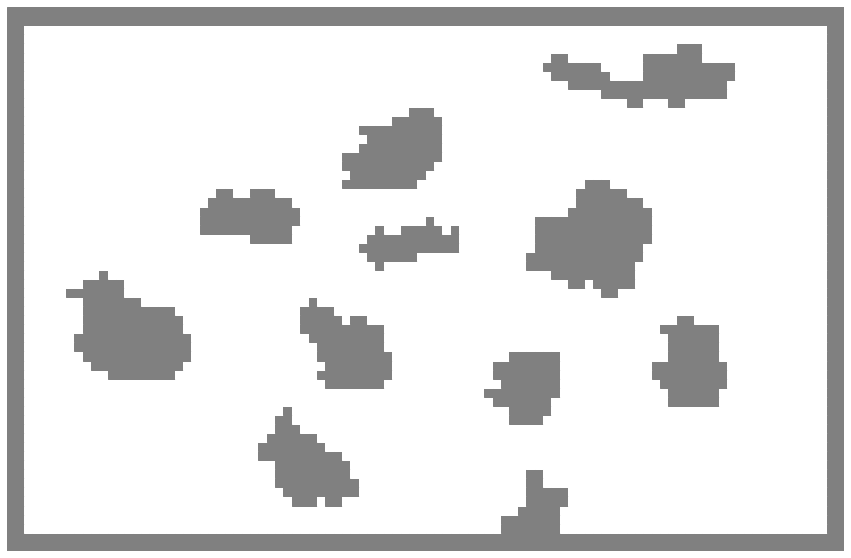

In [35]:
def process_map():
    fig, ax = fig, ax = plt.subplots(1, figsize=(15,10))

    padding=0
    ax.set_xlim(0-padding, 100+padding)
    ax.set_ylim(0-padding, 60+padding)

    ax.axis('off')

    # Add obstacles
    if (config_dict['use_occupancy_grid'][0] == 0):
        if config_dict['obstacle_cost'][0] > 0:
            for obstacle_nr in range(0,4):
                obst_id_rad = 'obstacle_rad_'+str(obstacle_nr)
                obst_id_x = 'obstacle_pos_'+str(obstacle_nr)+'_x'
                obst_id_y = 'obstacle_pos_'+str(obstacle_nr)+'_y'

                ellipse_plot_0 = patches.Circle((config_dict[obst_id_x][0],config_dict[obst_id_y][0]), 
                                         radius=config_dict[obst_id_rad][0], color='gray')

                ax.add_patch(ellipse_plot_0)
    else:
        grid = pd.read_csv(config_dict['grid_path'][0], header=None).to_numpy()

        for row in range(0, grid.shape[0]):
            for column in range(0, grid.shape[1]):
                if (grid[59-row, column] == 0):
                    color='w'
                else:
                    color='gray'

                grid_cell = patches.Rectangle((column, row),1,1, color=color)

                ax.add_patch(grid_cell)

    fig.savefig('rendered_grid.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format=None,
            transparent=False, bbox_inches='tight', pad_inches=0,
            metadata=None)

process_map()

In [36]:
def draw_interactive(simstep, step):
    
    img = plt.imread("rendered_grid.png")
    
    fig, ax = fig, ax = plt.subplots(1, figsize=(15,10))
    
    ax.imshow(img, extent=[0, 100, 0, 60])

    padding=2
    ax.set_xlim(0-padding, 100+padding)
    ax.set_ylim(0-padding, 60+padding)
    
    
    
    # filter data down to relevant data
    df_timestep = filter_df(sampling_df, "simstep", simstep, op='==')
    df_timestep = filter_df(df_timestep, "step", step, op='==')

    # plot start and target position
    ax.scatter(config_df.loc[0,'start_state_0'], config_df.loc[0,'start_state_1'], s=60, marker='o', c='k',zorder=20)
    ax.scatter(config_df.loc[0,'target_state_0'], config_df.loc[0,'target_state_1'], s=60, marker='x', c='k',zorder=20)
    
    # plot path of different rollouts
    for idx, row in df_timestep.iterrows():
        path = get_path(row['path_to_leaf'])
        df_path = filter_df(sampling_df, "node_id", path, op='isin')
        
        ax.plot(df_path[['state_0']], df_path[['state_1']], marker='.', zorder=10)
    
       
    # plot robot, actual and planned path
    ax.plot(sim_df[['state_0']], sim_df[['state_1']], c='k', alpha=0.3)
    ax.plot(sim_df[['state_0']][:simstep+1], sim_df[['state_1']][:simstep+1], c='r')
    ax.scatter(sim_df[['state_0']].iloc[simstep], sim_df[['state_1']].iloc[simstep],s=50, marker='D', c='r',zorder=20)
    
    padding=2
    ax.set_xlim(0-padding, 100+padding)
    ax.set_ylim(0-padding, 60+padding)

    
# def on_button_press_map(*arg):
#     process_map()
    
# def on_button_press_data(*arg):
#     load_data()
    
# load_data_button = widgets.Button(description='load data')
# load_data_button.on_click(on_button_press_map)


# load_map_button = widgets.Button(description='load map')
# load_map_button.on_click(on_button_press_data)

# display(load_data_button, load_map_button)
    
controls = widgets.interactive(draw_interactive, 
                    simstep = widgets.IntSlider(value=0, min=0, max=config_dict['sim_time'][0]-1, step=1), 
                    step= widgets.IntSlider(value=19, min=0, max=config_dict['horizon'][0]-1))



display(controls)





interactive(children=(IntSlider(value=0, description='simstep', max=149), IntSlider(value=19, description='ste…